In [12]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
# Loading the dataset
dataset = pd.read_csv('pulsar_stars.csv')

1. Once the dataset is loaded, let's see some relevant information about the dataset such as column's titles and types, number of records and shape.

In [14]:
# EDA
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None


2. Now, let's divide our dataset into two subsets: data and target.

In [15]:
# Droping the target column
data = dataset.drop(['target_class'], axis=1)

# Normalizing the data for all data points to fit in the range [0,1]
data = data / np.max(data)

target = dataset[['target_class']]

In [16]:
# Construct the training and testing splits 
trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.25)

Machine Learning algorithms works better when integer labels are transformed into vector labels. In order to accomplish this transformation I will instantiate a LabelBinarizer object and apply the transformation methods into our trainY and testY sets.

In [17]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

With keras, it is possible to define models to our neural network (nn). In this case, we are going to work with a Sequential nn, which is just the nn as we already know, i.e., each layer has as its input the output of the former layer. It is worth mention that our neural network is 8-4-2-1.

In [18]:
# Defining the model
model = Sequential()
model.add(Dense(4, input_shape=(8,), activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

We are going to use the Stochastic Gradient Descent technique as an optimizer, initially with a learning rate = 0.1. Furthermore, as this is a binary classification problem, in this case a common loss function to use is the binary cross-entropy. Also, our dataset is extremely unbalanced instances of classes, in order to achieve more balance between classes, we weighted the class 1 (is pulsar) ten times more than class 0 (not a pulsar).

In [19]:
# Stochastic Gradient descent optimizer with learning rate = 0.1
sgd = SGD(0.11)

model.compile(loss='binary_crossentropy', optimizer=sgd,
    metrics=["accuracy"])

class_weight = { 0 : 1., 1 : 10.}

H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              batch_size=128, epochs=200, class_weight=class_weight)

Train on 13423 samples, validate on 4475 samples
Epoch 1/200
13423/13423 [==============================] - 1s 92us/step - loss: 1.2588 - acc: 0.6697 - val_loss: 0.7203 - val_acc: 0.0927
Epoch 2/200
13423/13423 [==============================] - 0s 23us/step - loss: 1.2540 - acc: 0.5950 - val_loss: 0.7332 - val_acc: 0.0927
Epoch 3/200
13423/13423 [==============================] - 0s 23us/step - loss: 1.2461 - acc: 0.6291 - val_loss: 0.6675 - val_acc: 0.9466
Epoch 4/200
13423/13423 [==============================] - 0s 26us/step - loss: 1.2316 - acc: 0.7901 - val_loss: 0.6547 - val_acc: 0.9582
Epoch 5/200
13423/13423 [==============================] - 0s 20us/step - loss: 1.1953 - acc: 0.8888 - val_loss: 0.6004 - val_acc: 0.9569
Epoch 6/200
13423/13423 [==============================] - 0s 24us/step - loss: 1.1060 - acc: 0.9521 - val_loss: 0.5505 - val_acc: 0.9526
Epoch 7/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.9253 - acc: 0.9514 - val_loss: 0.4322 - v

13423/13423 [==============================] - 0s 21us/step - loss: 0.3270 - acc: 0.9587 - val_loss: 0.1592 - val_acc: 0.9575
Epoch 60/200
13423/13423 [==============================] - 0s 22us/step - loss: 0.3277 - acc: 0.9589 - val_loss: 0.1484 - val_acc: 0.9600
Epoch 61/200
13423/13423 [==============================] - 0s 24us/step - loss: 0.3267 - acc: 0.9587 - val_loss: 0.1492 - val_acc: 0.9600
Epoch 62/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.3255 - acc: 0.9592 - val_loss: 0.1945 - val_acc: 0.9441
Epoch 63/200
13423/13423 [==============================] - 0s 26us/step - loss: 0.3283 - acc: 0.9587 - val_loss: 0.1367 - val_acc: 0.9642
Epoch 64/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.3242 - acc: 0.9594 - val_loss: 0.1572 - val_acc: 0.9575
Epoch 65/200
13423/13423 [==============================] - 0s 24us/step - loss: 0.3242 - acc: 0.9589 - val_loss: 0.1344 - val_acc: 0.9658
Epoch 66/200
13423/13423 [==============

Epoch 118/200
13423/13423 [==============================] - 0s 22us/step - loss: 0.3110 - acc: 0.9622 - val_loss: 0.1227 - val_acc: 0.9707
Epoch 119/200
13423/13423 [==============================] - 0s 20us/step - loss: 0.3135 - acc: 0.9628 - val_loss: 0.1745 - val_acc: 0.9524
Epoch 120/200
13423/13423 [==============================] - 0s 21us/step - loss: 0.3123 - acc: 0.9624 - val_loss: 0.1416 - val_acc: 0.9629
Epoch 121/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.3122 - acc: 0.9637 - val_loss: 0.2169 - val_acc: 0.9370
Epoch 122/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.3130 - acc: 0.9629 - val_loss: 0.1500 - val_acc: 0.9611
Epoch 123/200
13423/13423 [==============================] - 0s 26us/step - loss: 0.3133 - acc: 0.9628 - val_loss: 0.1749 - val_acc: 0.9526
Epoch 124/200
13423/13423 [==============================] - 0s 22us/step - loss: 0.3096 - acc: 0.9619 - val_loss: 0.1119 - val_acc: 0.9736
Epoch 125/200
13423/

13423/13423 [==============================] - 0s 29us/step - loss: 0.3079 - acc: 0.9645 - val_loss: 0.1415 - val_acc: 0.9638
Epoch 177/200
13423/13423 [==============================] - 0s 19us/step - loss: 0.3092 - acc: 0.9640 - val_loss: 0.1351 - val_acc: 0.9651
Epoch 178/200
13423/13423 [==============================] - 0s 23us/step - loss: 0.3120 - acc: 0.9631 - val_loss: 0.1261 - val_acc: 0.9689
Epoch 179/200
13423/13423 [==============================] - 0s 24us/step - loss: 0.3060 - acc: 0.9646 - val_loss: 0.1494 - val_acc: 0.9622
Epoch 180/200
13423/13423 [==============================] - 0s 26us/step - loss: 0.3096 - acc: 0.9637 - val_loss: 0.1369 - val_acc: 0.9649
Epoch 181/200
13423/13423 [==============================] - 0s 24us/step - loss: 0.3060 - acc: 0.9635 - val_loss: 0.2017 - val_acc: 0.9428
Epoch 182/200
13423/13423 [==============================] - 0s 26us/step - loss: 0.3064 - acc: 0.9639 - val_loss: 0.1723 - val_acc: 0.9537
Epoch 183/200
13423/13423 [=======

At this point we are ready to analyze the results from our neural network. Calling the .predict method on our model will give us the predictions from our testing set. In addition, as the output from our network is given by the sigmoid activation function, the outputs values are real number in the range [0,1], so, we need to apply a step function to threshold the outputs to binary class labels. Lastly, we print a report showing us the performance of the model.

In [20]:
predictions = model.predict(testX, batch_size=128)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

print(classification_report(testY, predictions,
    target_names=['Non-pulsar Star', 'Pulsar Star']))

                 precision    recall  f1-score   support

Non-pulsar Star       0.99      0.98      0.98      4060
    Pulsar Star       0.80      0.90      0.84       415

      micro avg       0.97      0.97      0.97      4475
      macro avg       0.89      0.94      0.91      4475
   weighted avg       0.97      0.97      0.97      4475



Look at the above situation, we can see that there way more instances of non-pulsar stars than pulsar stars in our test set, this is called class imbalance. This implies that we can not probe the performance of our model only by taking into account the precision values. In fact, we have 17898 total examples and among those we have 1639 positive and 16259 negative examples.

It is also important to visualize the confusion matrix of our predictions, this can lead us to a more precise visualization and comprehension about where the numbers in our report came from.

In [21]:
# Confusion matrix
print(confusion_matrix(testY, predictions))

[[3966   94]
 [  43  372]]


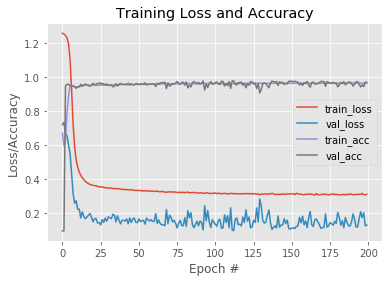

In [22]:
# Plotting the curve Epoch vs. Loss/Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 200), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 200), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 200), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 200), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('plot_complex.png')